# Clusterización: Extracción de Colores Predominantes en Imágenes
### Itzanami Berlanga Contreras | 07 de Abril del 2024

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import random 
import math
from skimage import io
from scipy.stats import norm, multivariate_normal

## Carga de la Imagenes

[[[0.34901961 0.55686275 0.38431373]
  [0.34901961 0.55686275 0.38431373]
  [0.34901961 0.55686275 0.38431373]
  ...
  [0.30196078 0.52156863 0.34509804]
  [0.30196078 0.52156863 0.34509804]
  [0.30196078 0.52156863 0.34509804]]

 [[0.34509804 0.55294118 0.38039216]
  [0.34509804 0.55294118 0.38039216]
  [0.34509804 0.55294118 0.38039216]
  ...
  [0.30196078 0.52156863 0.34509804]
  [0.30196078 0.52156863 0.34509804]
  [0.30196078 0.52156863 0.34509804]]

 [[0.3372549  0.54509804 0.37254902]
  [0.3372549  0.54509804 0.37254902]
  [0.3372549  0.54509804 0.37254902]
  ...
  [0.30196078 0.52156863 0.34509804]
  [0.30196078 0.52156863 0.34509804]
  [0.30196078 0.52156863 0.34509804]]

 ...

 [[0.35294118 0.68627451 0.22745098]
  [0.34117647 0.67058824 0.22352941]
  [0.35686275 0.68627451 0.24705882]
  ...
  [0.48627451 0.24705882 0.02352941]
  [0.53333333 0.2745098  0.03529412]
  [0.55294118 0.28627451 0.03137255]]

 [[0.34509804 0.67843137 0.21960784]
  [0.32156863 0.65098039 0.20392157]


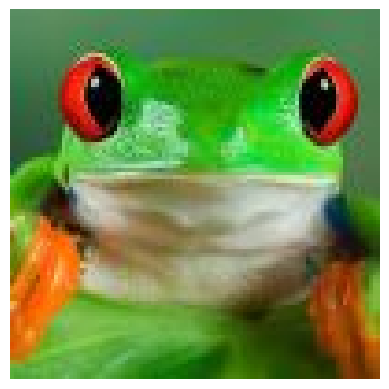

In [7]:
image=io.imread("Rana_100x100.jpg")/255.0  # imread lee las imagenes con los pixeles codificados como enteros, dividimos entre 255 para escalarlos de 0 a 1

# Como en este caso solo nos interesa la diferencia en el color y no las coordenadas del pixel, convertimos la matriz en un arreglo de colores:
colors_image = np.asarray(image)
print(colors_image)
color_array = np.reshape(colors_image, (10000, 3))
print(color_array)
print(color_array.shape[1])
print("- Dimensiones de la imagen:")
print(image.shape)
plt.axis('off')
plt.imshow(image)

## Gaussian Mixture Model

El algoritmo funciona de la siguiente manera

Expectation Step
Distribución Normal
$$\mathcal{N} (\mathbf{x} | \mu, \Sigma) = \frac{1}{(2\pi)^{D/2} |\Sigma|^{1/2}}\exp\left( -\frac{1}{2}(\mathbf{x} - \mu)^{T} \Sigma^{-1}(\mathbf{x} - \mu)\right)$$

Maximization step

$$ \mu_k = \frac{\sum_{n=1}^{N} \gamma(z_{nk})\mathbf{x}}{\sum_{n=1}^{N} \gamma(z_{nk})}$$


In [8]:
class GMM:
    def __init__(self, k_clusters = 3, tol = 1e-4):
        self.k = k_clusters
        self.means = None
        self.cov = None
        self.mix_prob = None
        self.tol = tol
        self.dim = None
        self.resp = None
        
    def cluster(self, X):
        self.dim = int(X[1].shape[0])
        print(self.dim)
        # Inicializamos las medias random, las inicializamos entre 0-1 que es donde se encuentran nuestros valores
        self.means = np.random.random((self.k, self.dim))
        # Al inicio inicializamos las probabilidades iguales para todos los clusters
        self.mix_prob = np.ones(self.k)/self.k          
        # Matriz de covarianzas
        aux = np.random.rand(self.k, self.k)
        self.cov = np.tril(aux) + np.tril(aux, -1).T
        logv = 0
        logv_ant = 10
        while self.tol > logv_ant - logv:
        #for i in range(1000):
            # E-step
            # Calcular las responsabilidades gamma usando los parámetros actuales
            self.resp = np.zeros((self.dim, self.k))
            for j in range(len(X)):
                self.resp[j] = self.__gamma(X[j])
            # M-step
            # Actualización de parámetros
            # Primero se actualizan las medias
            for j in range(self.k):
                mult = (np.array(self.resp[:,j]) * np.array(X).T).T
                num = mult.sum(axis=0)
                #num = np.sum(np.multiply(gamma[ :,j], X))
                den = np.sum(self.resp[:,j])
                self.means[j] = np.divide(num, den)
            # Después actualizamos la matriz de covarianza
            for j in range(self.k):
                resta = X - self.means[j]
                mult = np.array(self.resp[:,j])*(resta*resta.T)
                num = mult.sum(axis=0)
                den = np.sum(self.resp[:,j])
                self.cov[j] = np.divide(num, den)
            # Finalmente actualizamos las probabilidades de mezcla
            for j in range(self.k):
                self.mix_prob[j] = np.sum(self.resp[:,j])/len(X)
            # Calculamos la log-verosimilitud para comprobar convergencia
            logv_ant = logv
            logv = 0
            for k in range(len(X)):
                aux = 0
                for j in range(self.k):
                    aux += self.mix_prob[j]*multivariate_normal(self.means[j], self.cov[j]).pdf(X)
                logv += math.log(aux)
                
    def __gamma(self, x):
        gd = np.zeros(self.k)
        for i in range(self.k):
            gd[i] = multivariate_normal(self.means[i], self.cov[i]).pdf(x)
        prod = np.multiply(gd, self.mix_prob)
        denom = np.sum(prod)
        return np.divide(gd, denom)
    
    #def __actualizar_medias(self):
        
        
    def clusters(self):
        return self.means

3
[[114.34250728 205.36313831 252.98285443]
 [171.4874582   18.69905276  39.48249743]
 [  2.11781322  68.65670198  46.73587283]
 [114.0912507  155.16142774 219.21701285]
 [189.25893636 249.42641548   2.66132569]]


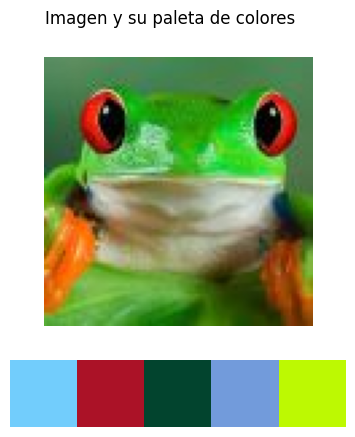

In [9]:
clust = GMM(5)
clust.cluster(color_array)
paleta = clust.clusters()
print(paleta*255.0)
paleta = np.array(paleta)[np.newaxis, :, :]
fig, axis = plt.subplots(2, gridspec_kw={'height_ratios': [4, 1]})
axis[1].imshow(paleta)
axis[1].axis('off')
axis[0].imshow(image)
axis[0].axis('off')
fig.suptitle("Imagen y su paleta de colores")
plt.show()